In [23]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using LaTeXStrings
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [17]:
function get_T(p)
    Tᵣ = p[1]^2#limit_func_abs(p[1])
    Tₐ = p[2]^2#limit_func_abs(p[2])
    Tₚ = p[3]^2 + 2*Tᵣ#limit_func_abs(p[3]) + 2*Tᵣ
    2*Tₐ + Tₚ
end

ls = readdlm("ls.txt")
ps = readdlm("params.txt") ;

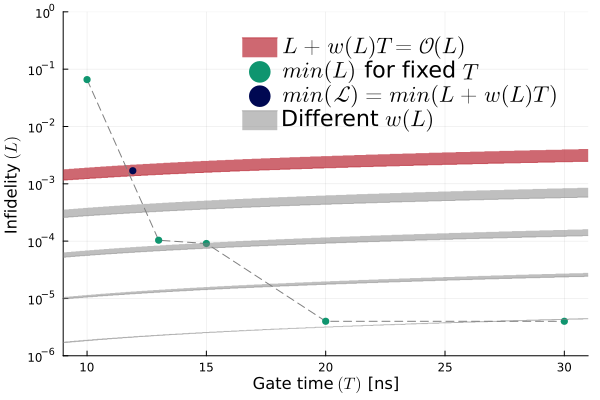

In [29]:
xs = 10 .^(LinRange(-7,-0.5,1000)[1:end-1])
# using LaTeXStrings

# function wT(L)
#      σ = 75e5
#      log(L)^4/σ
#  end

# poi = xs[argmin(abs.(wT.(xs)-xs))]
# plt = plot(xs,wT.(xs),
#      xscale=:log10,
#      yscale=:log10,
#      yticks=[10^i for i=-15.:0],
#      xticks=[10^i for i=-7.:0],
#      lw=2,
#      color=:green,
#      label=L"$w(L)=\frac{\ln(L)^4}{75e5}$"
#      )

# plot!([xs[1],poi,poi],[poi,poi,wT(xs[end])],ls=:dash,color=:black,lw=2,label=nothing)
# scatter!([poi],[poi],
# label=L"$w(L^*)=L^*\approx 4.6\cdot10^{-4}$",color=:orange,
# background_color_legend = nothing,
#       foreground_color_legend = nothing,
#       xlabel=L"Infidelity $(L)$",
# legend=:bottomleft,legendfontsize=13)
# # savefig(plt,"Tweightfunction.pdf")

function wT(L,σ=75e5)
    # σ = 75e5
    log(L)^4/σ
end
log10(4.641588833612791e-21), log10(75e5)
Ts = LinRange(11.9157,30,100)
sigmas = 10 .^ LinRange(log10(75e5),log10(1.1497569953977356e11),100)
# sigmas = LinRange(75e5,1.1497569953977356e11,100)

# pois = [xs[argmin(abs.(wT.(xs,sigmas[i])*Ts[i]-1.557896 .*xs))] for i in 1:100]
# plot(Ts,1 .- pois)#,yscale=:log10)
# plot!([11.9157,30],1 .- [1-0.9983096,1-0.999996])
# plot!([0.9998],seriestype=:hline)
# scatter!([11.9157,13,15,20],[0.9983096,1-0.00010369080576144718,1-9.1e-5,1-4e-6])
Ts = LinRange(8,32,1000)
poislower = [xs[argmin(abs.(wT.(xs,75e5)*Ts[i]-(10^0.5-1) .*xs))] for i in 1:1000] #1.557896
poishigher = [xs[argmin(abs.(wT.(xs,75e5)*Ts[i]-(10^(-0.5)-1) .*xs))] for i in 1:1000]
plt = plot(Ts,poislower,fillrange=poishigher,
     label=L"$L + w(L)T = \mathcal{O}(L)$",
     xlim=(9,31),
     yscale=:log10,
     ylim=(1e-6,1),
     alpha=0.7,
     color="#BA2936",
     xlabel=L"Gate time $(T)$ [ns]",
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=15,
     ) #["#0F956F" "#BA2936" "#000852"]
plot!([10,13,15,20, 30],1 .- [1 - 0.065715997881162,1-0.00010369080576144718,1-9.1e-5,1-4e-6, 0.999996],
     ls=:dash,
     color=:grey,
     label=nothing)
scatter!([10,13,15,20, 30],1 .- [1 - 0.065715997881162,1-0.00010369080576144718,1-9.1e-5,1-4e-6, 0.999996],
          color="#0F956F",
          markerstrokecolor="#0F956F",
        #   lw=20,
        #   widthcolor=:white,
          ylabel=L"Infidelity $(L)$",
          label=L"$min(L)$ for fixed $T$"
          )
scatter!([11.9157],[1-0.9983096],
         color="#000852",
         markerstrokecolor="#000852",
        #  markersize=5,
         label=L"$min(\mathcal{L})=min(L + w(L)T)$")

for sigma in [75e8 75e7 75e6 75e9]
plot!(Ts,[xs[argmin(abs.(wT.(xs,sigma)*Ts[i]-(10^0.5-1) .*xs))] for i in 1:1000],fillrange=[xs[argmin(abs.(wT.(xs,sigma)*Ts[i]-(10^(-0.5)-1) .*xs))] for i in 1:1000],
    label=nothing,#[if sigma==75e8 else nothing],
    color=:grey,
    alpha=0.5,
    )
end
plot!([0],[1],fillrange=[2],label=L"Different $w(L)$",color=:grey,alpha=0.5)
plt

In [72]:
Ts = LinRange(8,40,1000)
poislower = [xs[argmin(abs.(wT.(xs,75e5)*Ts[i]-(10^0.5-1) .*xs))] for i in 1:1000] #1.557896
poishigher = [xs[argmin(abs.(wT.(xs,75e5)*Ts[i]-(10^(-0.5)-1) .*xs))] for i in 1:1000]
plt = plot(Ts,poislower,fillrange=poishigher,
     label=L"$L + w(L)T = \mathcal{O}(L)$",
     # xlim=(9,31),
     yscale=:log10,
     ylim=(1e-6,1),
     alpha=0.7,
     color="#BA2936",
     ylabel=L"$L$",
     legend=:bottomright,
     xlabel=L"Gate time $(T)$ [ns]",
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=15,
     )


Ts = [get_T(ps[i,:]) for i in 1:size(ps)[1]];
# get_T(ps[1,:])
plot!(Ts,ls*(ls[end]\(1-0.9983096)),yscale=:log10,ylim=(1e-6,1),color=:blue,alpha=0.5,marker=:o,label=L"$\mathcal{L}=L_i + w(L_i)T_i$  for the optimization run")

plot!([10,13],1 .- [1 - 0.065715997881162,1-0.00010369080576144718],
     ls=:dash,
     color=:grey,
     label=nothing)
# savefig(plt,"InfidelityTimeDependence_OptRun.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\FastGate\\InfidelityTimeDependence_OptRun.pdf"

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const .* (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [7]:
# function limit_func(param,pmin,pmax)
#     if pmin < param < pmax
#         return param
#     elseif param <= pmin
#         return pmin
#     else
#         return pmax
#     end
# end

function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

function limit_func_abs(param)
    param^2
end

limit_func_abs (generic function with 1 method)

In [5]:
# xs = LinRange(-10,10,1000)
# plt = plot(xs, [limit_func(x,-2,5) for x in xs],
#      label=nothing,
#      yticks=([-2,5], [L"$p_{min}$",L"$p_{max}$"]),
#      ytickfontsize=20,
#      ylim=(-3,6),
#      xlabel=L"̃p",
#      xlabelfontsize=20,
#      title=L"$p=\sigma(̃p|p_{min},p_{max})$",
#      titlefontsize=20,
#      lw=2,
#      color=:green
#     #  ylabels=[L"$p_\text{min}$",""],
#      )
# # savefig(plt,"LimitingFunction.pdf")

In [8]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
p = [2, 10, 6, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
p[1] = sqrt(p[1])
p[2] = sqrt(p[2])#inv_limit_func(p[2],0,15)
p[3] = sqrt(p[3])
p[4] = inv_limit_func(p[4],0.5,1)

function alpha(p, t)
    Tᵣ = limit_func_abs(p[1])
    Tₐ = limit_func_abs(p[2])
    Tₚ = limit_func_abs(p[3]) + 2*Tᵣ
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tᵣ = limit_func_abs(p[1])
    Tₐ = limit_func_abs(p[2])
    Tₚ = limit_func_abs(p[3]) + 2*Tᵣ
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = limit_func(p[8],0.961pi,1.039pi)
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [9]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3))
ψ0 = ψs[:,1:2]
sizep = length(p);

function f!(du, u, p, t)
    x = u[:,1:2]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling

    du[:,1:2] = -im .* (H * x)
end

function b!(du, u, p, t)
    x = u[:,1:2]
    λ = u[:,3:4]
    ps = u[:,5]

    miH = -im .* (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * λ
    
    du[1:sizep,5] = 2 .* (- real(im * tr(λ' * chargecoupling * x)) .* dpulsedp(p, t)
                     - real(im * tr(λ' * Potential3 * x)) .* dalphadp(p,t))
end

b! (generic function with 1 method)

In [8]:
function get_T(p)
    Tᵣ = limit_func_abs(p[1])
    Tₐ = limit_func_abs(p[2])
    Tₚ = limit_func_abs(p[3]) + 2*Tᵣ
    2*Tₐ + Tₚ
end
dTdp(p) = ForwardDiff.gradient(p̃ -> get_T(p̃), p)

dTdp (generic function with 1 method)

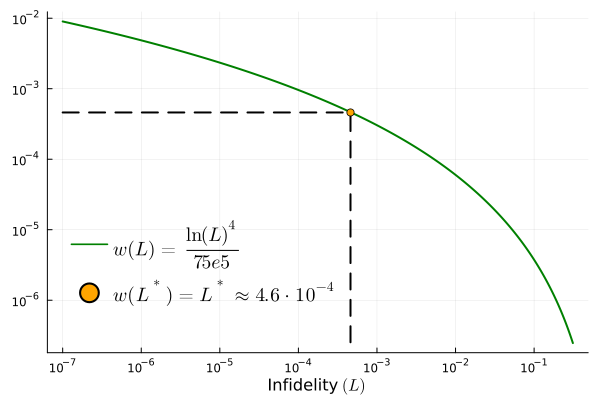

In [201]:
xs = 10 .^(LinRange(-7,-0.5,1000)[1:end-1])
using LaTeXStrings

function wT(L)
     σ = 75e5
     log(L)^4/σ
 end

poi = xs[argmin(abs.(wT.(xs)-xs))]
plt = plot(xs,wT.(xs),
     xscale=:log10,
     yscale=:log10,
     yticks=[10^i for i=-15.:0],
     xticks=[10^i for i=-7.:0],
     lw=2,
     color=:green,
     label=L"$w(L)=\frac{\ln(L)^4}{75e5}$"
     )

plot!([xs[1],poi,poi],[poi,poi,wT(xs[end])],ls=:dash,color=:black,lw=2,label=nothing)
scatter!([poi],[poi],
label=L"$w(L^*)=L^*\approx 4.6\cdot10^{-4}$",color=:orange,
background_color_legend = nothing,
      foreground_color_legend = nothing,
      xlabel=L"Infidelity $(L)$",
legend=:bottomleft,legendfontsize=13)
# savefig(plt,"Tweightfunction.pdf")

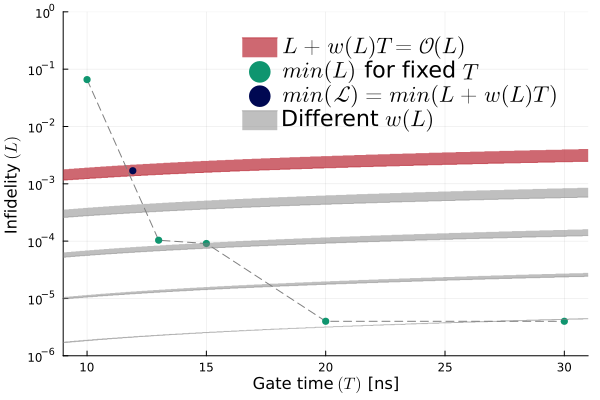

In [198]:
function wT(L,σ=75e5)
    # σ = 75e5
    log(L)^4/σ
end
log10(4.641588833612791e-21), log10(75e5)
Ts = LinRange(11.9157,30,100)
sigmas = 10 .^ LinRange(log10(75e5),log10(1.1497569953977356e11),100)
# sigmas = LinRange(75e5,1.1497569953977356e11,100)

# pois = [xs[argmin(abs.(wT.(xs,sigmas[i])*Ts[i]-1.557896 .*xs))] for i in 1:100]
# plot(Ts,1 .- pois)#,yscale=:log10)
# plot!([11.9157,30],1 .- [1-0.9983096,1-0.999996])
# plot!([0.9998],seriestype=:hline)
# scatter!([11.9157,13,15,20],[0.9983096,1-0.00010369080576144718,1-9.1e-5,1-4e-6])
Ts = LinRange(8,32,1000)
poislower = [xs[argmin(abs.(wT.(xs,75e5)*Ts[i]-(10^0.5-1) .*xs))] for i in 1:1000] #1.557896
poishigher = [xs[argmin(abs.(wT.(xs,75e5)*Ts[i]-(10^(-0.5)-1) .*xs))] for i in 1:1000]
plt = plot(Ts,poislower,fillrange=poishigher,
     label=L"$L + w(L)T = \mathcal{O}(L)$",
     xlim=(9,31),
     yscale=:log10,
     ylim=(1e-6,1),
     alpha=0.7,
     color="#BA2936",
     xlabel=L"Gate time $(T)$ [ns]",
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=15,
     ) #["#0F956F" "#BA2936" "#000852"]
plot!([10,13,15,20, 30],1 .- [1 - 0.065715997881162,1-0.00010369080576144718,1-9.1e-5,1-4e-6, 0.999996],
     ls=:dash,
     color=:grey,
     label=nothing)
scatter!([10,13,15,20, 30],1 .- [1 - 0.065715997881162,1-0.00010369080576144718,1-9.1e-5,1-4e-6, 0.999996],
          color="#0F956F",
          markerstrokecolor="#0F956F",
        #   lw=20,
        #   widthcolor=:white,
          ylabel=L"Infidelity $(L)$",
          label=L"$min(L)$ for fixed $T$"
          )
scatter!([11.9157],[1-0.9983096],
         color="#000852",
         markerstrokecolor="#000852",
        #  markersize=5,
         label=L"$min(\mathcal{L})=min(L + w(L)T)$")

for sigma in [75e8 75e7 75e6 75e9]
plot!(Ts,[xs[argmin(abs.(wT.(xs,sigma)*Ts[i]-(10^0.5-1) .*xs))] for i in 1:1000],fillrange=[xs[argmin(abs.(wT.(xs,sigma)*Ts[i]-(10^(-0.5)-1) .*xs))] for i in 1:1000],
    label=nothing,#[if sigma==75e8 else nothing],
    color=:grey,
    alpha=0.5,
    )
end
plot!([0],[1],fillrange=[2],label=L"Different $w(L)$",color=:grey,alpha=0.5)
plt

# plot!([4.6e-4],seriestype=:hline)
# scatter!([10,13,15,20],T_losses)
# savefig(plt,"InfidelityTimeDependence.pdf")

In [91]:
10^(-0.5)

0.31622776601683794

In [75]:
T_losses = []
for T in [10 13 15 20]
    println(T)
    function alpha(p, t)
        Tₐ = limit_func(p[2],0,T/2)
        Tₚ = T - 2*Tₐ#p[3]
        αmin = limit_func(p[4],0.5,1)
        abs_slope = (1 - αmin)/Tₐ
        if t < Tₐ
            return 1 - abs_slope * t
        elseif t > Tₐ + Tₚ
            return αmin + abs_slope * (t - Tₐ - Tₚ)
        else
            return αmin
        end
    end
    function pulse(p, t)
        Tₐ = limit_func(p[2],0,T/2)
        Tₚ = T - 2*Tₐ#p[3]
        Tᵣ = limit_func(p[1],0,Tₚ/2)
        # αmin = p[4]
        ϕ = p[5]
        f = p[6]
        A = p[7]
        # Φ_ext = p[8]
        λ = p[9]
    
        amp = pi * A #/ (Tₚ - Tᵣ)
        E = amp
        Edot = copy(amp)
        E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
        arg = f*(t - Tₐ) + ϕ
        return E*cos(arg) + Edot*λ*sin(arg)
    end
    p_new = readdlm("tmp_paramsT"*string(T)*".txt")[end,:]
    forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, T), p_new)
    sol_f = solve(forward_prob, p=p_new, save_everystep=false, reltol=1e-10, abstol=1e-10)
    UT = abs2.(ψs[:,1:2]'*sol_f.u[end][:,1:2])
    push!(T_losses,0.5 * (2 - UT[1,2] - UT[2,1]))
end

10


13


15


20

In [55]:
T = 13
function alpha(p, t)
    Tₐ = limit_func(p[2],0,T/2)
    Tₚ = T - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

# dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
# ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,T/2)
    Tₚ = T - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A #/ (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

# dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)
ls = []
params = []

grad = zeros(sizep)
loss = [0.0]
call = [0]

function calc(p, last_p, grad, loss)
    if p != last_p
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, ψ0, (0.0, T), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        xT = sol_f.u[end][:,1:2]

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])

        λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,λ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (T, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        
        # grad_phi = real(sol_b.u[end][8,9])

        loss[1] = infidelity
        grad[:] = real(sol_b.u[end][1:sizep,5])# + m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,9])

        push!(ls, copy(infidelity))
        # push!(l2s, copy(grad_phi))
        push!(params, copy(p))
        call[1] += 1

        if call[1]%5 == 0
            image = plot(ls,yscale=:log10,ylim=(1e-6,2))
            savefig(image,"tmp_loss.png")

            writedlm("tmp_lsT13.txt",ls)
            writedlm("tmp_paramsT13.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    println(ls[end])
end
# p = [1.5, 7, 10, 0.7, 0, 0.98*2.48, 1/(0.295*4.5), 0.995pi, 0.0] #20
# p = [1, 3, 10, 0.7, 0, 0.98*2.48, 1/(0.295*2), 0.995pi, 0.0] #10
# p = [1.5, 5, 10, 0.7, 0, 0.98*2.48, 1/(0.295*2), 0.995pi, 0.0] #15
p = [1.5, 4, 10, 0.7, 0, 0.98*2.48, 1/(0.295*2), 0.995pi, 0.0] #13
p[1] = inv_limit_func(p[1],0,T/2 - p[2])
p[2] = inv_limit_func(p[2],0,T/2)
p[4] = inv_limit_func(p[4],0.5,1)

-0.40546510810816466

In [56]:
initial_p = copy(p)
last_p = similar(initial_p);

In [57]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()))

0.6491663206470017


0.6726094065118056


0.37424122267693494


0.9805036797894618


0.34173775456450295


0.6109386646959216


0.039758544343910907


0.5267310851340609


0.005726501157597319


0.0021220036950313492


0.0017127664665859132


0.0016665032879958908


0.001647862898937813


0.0015995540872223435


0.0015846414622550653


0.001559578077581114


0.0015057926726707027


0.0014359107159379603


0.00130762476221008


0.0012069355268985449


0.001143995646027296


0.0010141200747599277


0.0009765673220008542


0.0009404455860249628


0.0008855931589659138


0.000853786139738244


0.0009958949659277239


0.0006887016334548024


0.0035721033777184608


0.0006571236500897415


0.0006631575926875355


0.000612770865376755


0.0005525175433258034


0.0004511747758394469


0.0003857317403705429


0.00027790610791422754


0.0005366194319743611


0.0002196493944478517


0.00018759795984180094


0.00018574349122169043


0.00018551694603702318


0.0001851757655995656


0.00018382920699017147


0.00018124530681873363


0.0001773819261330356


0.00017306938125627447
0.00016949920462916435


0.00016826328385166622


0.00016808913293536731


0.000167971180809523


0.00016795849738693303


0.00016794561123023577
0.0001679414953085212


0.00016792343862670478


0.00016789231269043192


0.00016777602585549278


0.0001675093646121839


0.0001666669317222924


0.00016534851517507887


0.0001620777530667583


0.0001593516799366923


0.00015735193516580592


0.0001491581303786349


0.00014870908835007413


0.00014538560940957623


0.00014286915580202786


0.0001429000989728313


0.00030342453826703863


0.00014080498740126624


0.00013948899896276679


0.0001400863887366377


0.00013924921195102025


0.0001390148416599013


0.00013888118270471983


0.00013837550230388906


0.00013677228101838246


0.00013427141395327968


0.00013390084794373536


0.0001330700828319209


0.00013681460373782262


0.00013252195157020807


0.00013196840987472758


0.00013081822668725707


0.0001288432434808362


0.0001239070146440424


0.00043302274327050583


0.00012317741965239826


0.00011955144355679792


0.00011257576977696804


0.00010849364709819564


0.00010766117398430808


0.00010728200255955


0.00010714229020802879


0.00010711840864030542


0.00010711641664690186


0.00010711437727900508


0.00010709899968003311


0.00010706806644605882


0.00010699526911805979


0.00010688956091059465


0.00010659477215591018


0.00010651244768000723


0.00010633467720266854


0.00010629738877365735


0.00010623836223722094


0.00010661373509751604


0.00010614407392700587


0.00010608434537057176


0.00010599726812665633


0.0001059277411420978


0.00010591700686729544


0.00010589691193257922


0.00010585327855722193


0.00010582920726792677


0.00010579055411030769


0.00010579150921280478


0.00010577925571447766


0.00010576896529562729


0.00010576120179217607


0.00010575422180086891


0.0001057462208524651


0.00010574054628031959


0.00010574333438367889


0.00010573639133265589


0.00010572575209050195


0.0001057107956015102


0.00010668428074595004


0.00010569954969641415


0.00010577666045957779


0.0001056923271457455


0.00010567802480287991


0.00010562007104969462


0.0001054750081395106


0.00010512947842628018


0.00010483707875547088


0.00010469649442712559


0.0002955812062430674


0.00010464634649826055


0.00010421705357360755


0.00010404298579658189


0.0001040103759256672


0.00010397734883205167


0.00010396200975709702


0.00010395385878569918


0.00010394809762592772


0.0001039284551322961


0.0001039057809086863


0.00010384939774121804


0.00010386246972687863


0.00010383923368484371


0.00010381835689166063


0.00010379673583366111


0.00010389181081205123


0.00010378181145653809


0.0001037551867673625


0.00010375549469032741


0.00010374681631319937


0.00010374250263861517


0.00010374063934076583


0.00010373902519800193


0.00010373733209845248


0.00010373800712487613


0.00010373701905741495


0.00010373694766085961


0.00010373750993442066


0.00010373737799668215


0.00010373694517484822


0.00010373694350879203


0.00010373673912306147


0.00010373495252685716


0.00010372798147539886


0.00010371529248393019


0.00010370955279792593


0.00010369961797723759


0.00010369332200504955


0.00010369163041601404


0.00010369322399261804


0.00010369191491305108


0.00010369163040052642


0.00010369177093422222


0.00010369169692325819


0.00010369163055951036


0.00010369162990431224


0.00010369163047901919


0.00010369162939494192


0.00010369162986512137


0.00010369163077217358


0.00010369162965745415


0.0001036916295890089


0.00010369162939494192


0.00010369167767465548


0.00010369168135027085


0.00010369162714057856


0.0001036916523893261


0.00010369162714413127


0.00010369162658241393


0.00010369162670403886


0.00010369162620127437


0.00010369162707646318


0.00010369162760337503


0.00010369162683576683


0.00010369162720041958


0.00010369162620127437


0.00010369162753298689


0.00010369162620127437


0.00010369162660456288


0.00010369162620127437
0.00010369162623674599


0.00010369162620127437


0.00010369162637441365


0.00010369162620127437


0.00010369162680590183


0.00010369162620127437


0.00010369162646634011


0.00010369162620127437


0.00010369173577973179


0.00010369161610296329


0.00010369153097405936


0.00010369150165739915


0.00010369182587455228


0.00010369151493494488


0.00010369150162892193


0.00010369150166328334


0.00010369150170719266


0.00010369150161759766


0.00010369150162164997


0.00010369150161759766


0.00010369308268343147


0.00010369228888218451


0.00010369150159955653


0.00010369150160205454


0.00010369150165079333


0.00010369150160677298


0.00010369150159955653


0.00010369150150985051


0.00010369150163841434


0.00010369150150985051


0.00010369150161126939


0.00010369150150985051


0.0001036915015237283


0.00010369150150985051


0.00010369150151645634


0.00010369150150985051


0.00010369150151906537


0.00010369150150985051


0.00010369150151839923


0.00010369150150985051


0.00010369150152106377


0.00010369150150985051


0.00010369080585626023


0.00010369081075789488


0.0001036908058994479


0.00010369080587480095


0.00010369080584238244


0.00010369080580391321


0.00010369080586319912


0.00010369080585592716


0.00010369080580391321


0.00010369080582561807


0.00010369080580391321


0.00010369080585970192


0.00010369080580391321


0.00010369080585259649


0.00010369080580391321


0.00010369080579597512


0.00010369080579830658


0.00010369080579597512


0.00010369080582584012


0.00010369080579597512


0.00010369080581856815


0.00010369080579597512


0.00010369080578720435


0.00010369080578931378


0.00010369080578720435


0.00010369080578753742


0.00010369080578720435


0.0001036908057864272


0.00010369080578798151


0.0001036908057864272


0.00010369080578953582


0.0001036908057864272


0.00010369080579331058


0.0001036908057864272


0.00010369080578809253


0.0001036908057864272


0.00010369080578809253


0.0001036908057864272


0.0001036908057864272


0.00010369081167571625


0.00010369080586303259


0.00010369080582950385


0.00010369080578459533


0.0001036908058416608


0.00010369080579619716


0.00010369080578459533


0.00010369080583477741


0.00010369080578459533


0.00010369080582206536


0.00010369080578459533


0.000103690805852652


0.00010369080578459533


0.00010369080581773549


0.00010369080578459533


0.00010369080582023349


0.00010369080578459533


0.00010369080581856815


0.00010369080578459533


0.00010369080578348511


0.0001036908058162922


0.00010369080578348511


0.00010369080580463486


0.00010369080578348511


0.00010369080578653822


0.00010369080578348511


0.00010369080579131218


0.00010369080578348511


0.00010369080579059053


0.00010369080578348511


0.00010369080579059053


0.00010369080578348511


0.00010369080579059053


0.00010369080578348511


0.00010369080579059053


0.00010369080578348511


0.0001036923139295376


0.00010369080652605778


0.00010369080577443679


0.00010369080578703782


0.00010369080587002699


0.0001036908057615582


0.0001036908057764907


0.0001036908057615582


0.00010370348984550803


0.00010369081243005729


0.0001036908058078545


0.00010369080581373868


0.00010369080586297708


0.0001036908057615582


0.00010369080580446832


0.0001036908057615582


0.0001036908058904551


0.0001036908057615582


0.00010369080584232693


0.0001036908057615582


0.00010369080586020152


0.0001036908057615582


0.00010369080588423785


0.0001036908057615582


0.00010369080577821155


0.0001036908057615582


0.00010369080586880575


0.0001036908057615582


0.00010369080586830615


0.0001036908057615582


0.00010369080586913881


0.0001036908057615582


0.00010369080577415923


0.0001036908057615582


0.00010369080576144718


0.00010369080576527745


0.00010369080576144718


0.00010369080576866363


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.0001036916861378856


0.00010369080591021707


0.00010369080588906732


0.00010369080589023305


0.00010369080576144718


0.0001036908058571484


0.00010369080576144718


0.00010369080583055856


0.00010369080576144718


0.0001036908058575925


0.00010369080576144718


0.00010369080582794954
0.00010369080576144718

0.00010369080587885326


0.00010369080576144718


0.0001036908058705821


0.00010369080576144718


0.00010369080577138368


0.00010369080576144718


0.00010369080586963841


0.00010369080576144718


0.00010369080586902779


0.00010369080576144718


0.00010369080586991597


0.00010369080576144718


0.000103690805763057


0.00010369080576144718


0.00010369080576588807


0.00010369080576144718


0.00010369080576722034


0.00010369080576144718


0.00010369080577593559


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


0.00010369080577271594


0.00010369080576144718


 * Status: success

 * Candidate solution
    Final objective value:     1.036908e-04

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.08e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   2387  (vs limit Inf)
    Iterations:    158
    f(x) calls:    424
    ∇f(x) calls:   424


In [36]:
1399/122, 1030/172

(11.467213114754099, 5.988372093023256)

In [102]:
# pois = [xs[argmin(abs.(wT.(xs,10^σ)-xs))] for σ in LinRange(-21,8,100)]
pois

100-element Vector{Float64}:
 0.0016952323415541214
 0.0015966260221014252
 0.0015264538678574353
 0.0014593657991557576
 0.0013744790926775367
 0.0013140703572809013
 0.0012376350284724826
 0.0011832406274583781
 0.001114415251466787
 0.0010654363936533232
 ⋮
 6.939710303890459e-6
 6.438857427240413e-6
 6.064329395408062e-6
 5.626654522879045e-6
 5.299369772740128e-6
 4.916903577628041e-6
 4.562040738514225e-6
 4.296681214989711e-6
 3.986581073580439e-6

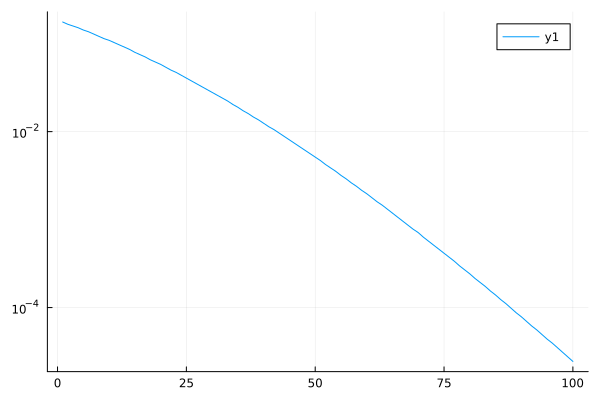

In [53]:
plot([xs[argmin(abs.(wT.(xs,10^σ)*30-1.557896 .*xs))] for σ in LinRange(3,10,100)],yscale=:log10)

In [29]:
function wT(L,σ=75e5)
    # σ = 75e5
    log(L)^4/σ
end
pois = [xs[argmin(abs.(wT.(xs,10^σ)-xs))] for σ in LinRange(-21,8,100)]

100-element Vector{Float64}:
 0.06085332099294108
 0.05817880074344935
 0.055621826396929315
 0.05317723177850969
 0.050084079898482126
 0.047882870766753884
 0.04577840538376619
 0.04311561990318226
 0.04122067651112278
 0.038822999746422976
 ⋮
 0.0001519433445132485
 0.00014097728716289693
 0.00012885762131855166
 0.00011955770713056357
 0.00010927945955821387
 0.00010139254075588153
 9.407483677622543e-5
 8.598732417732187e-5
 7.978144572076629e-5

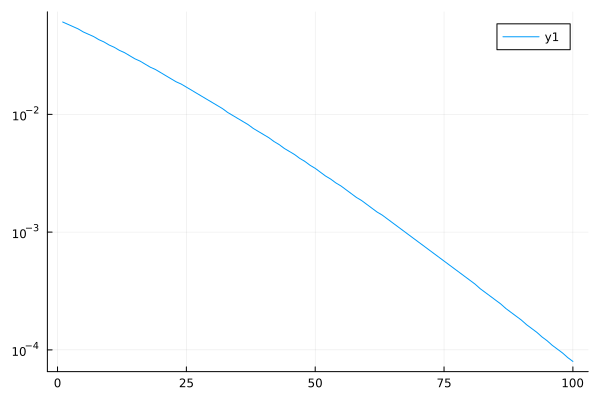

In [17]:
plot(pois,yscale=:log10)

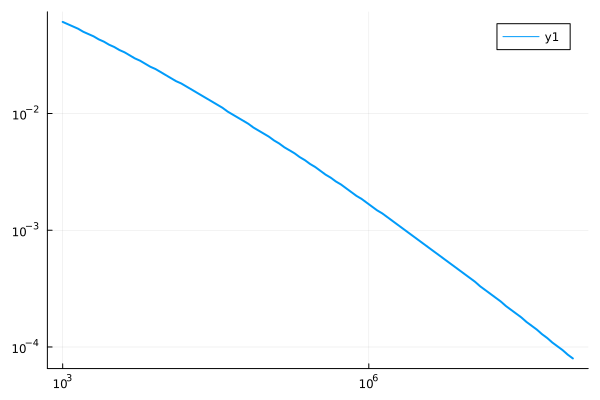

In [204]:
plot(10 .^LinRange(3,8,100),pois,
xscale=:log10,
yscale=:log10,
yticks=[10^i for i=-15.:0],
# xticks=[10^i for i=-7.:0],
lw=2,)


In [161]:
cat([10^i for i=-7.:0],[poi],dims=1)

9-element Vector{Float64}:
 1.0000000000000001e-7
 1.0e-6
 1.0e-5
 0.0001
 0.001
 0.010000000000000002
 0.1
 1.0
 0.0004620241371751313

In [150]:
1-0.9983096, poi*12#wT(0.0016903999999999808)*11.9157

(0.0016903999999999808, 0.005544289646101576)

In [7]:
function wT(L)
    σ = 75e5
    log(L)^4/σ
end

function dwTdL(L)
    σ = 75e5
    4* log(L)^3 /(σ*L)
end

# function f(p)
#     T = get_T(p)

#     forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, T), p)
#     sol = solve(forward_prob, p=p, save_everystep=false, reltol=1e-12, abstol=1e-12)

#     UT = abs2.(ψs[:,1:2]'*sol.u[end])
#     L = 0.5 * (2 - UT[1,2] - UT[2,1])
#     return L + wT(L) * T#L, wT(L) * T
# end

# function b(p)
#     T = get_T(p)

#     forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, T), p)
#     sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

#     xT = sol_f.u[end][:,1:2]

#     UT = abs2.(ψs[:,1:2]'*xT)
#     L = 0.5 * (2 - UT[1,2] - UT[2,1])

#     λ = (1 + dwTdL(L) * T) .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)

#     ps = zeros(289,1) #only 2*length(p) are possibly used
#     bu0 = cat(xT,λ,ps,dims=2)#cat(xT,ψT,λ,ϕ,ps,dims=2);

#     backward_prob = ODEProblem(b!, bu0, (T, 0.0), p)
#     sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)
    
#     grad = real(sol_b.u[end][1:sizep,5])
#     h̃ = -im .* ((KinPot12 + alpha(p, get_T(p)) .* Potential3 + pulse(p,get_T(p)) .* chargecoupling) * xT)

#     grad, - λ'*h̃, L
# end
    # UT = abs2.(ψ0'*xT)
    # infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])

    # loss[1] = infidelity
    # grad[:] = real(sol_b.u[end][1:sizep,5])

dwTdL (generic function with 1 method)

In [12]:
ls = []
params = []

grad = zeros(sizep)
loss = [0.0]
calls  = [1]

function calc(p, last_p, grad, loss)
    if p != last_p
        copy!(last_p, p)

        T = get_T(p)

        forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, T), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        xT = sol_f.u[end][:,1:2]

        UT = abs2.(ψs[:,1:2]'*xT)
        L = 0.5 * (2 - UT[1,2] - UT[2,1])

        λ = (1 + dwTdL(L) * T) .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,λ,ps,dims=2)#cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (T, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)
        
        # grad = real(sol_b.u[end][1:sizep,5])
        h̃ = -im .* ((KinPot12 + alpha(p, get_T(p)) .* Potential3 + pulse(p,get_T(p)) .* chargecoupling) * xT)

        # grad, - λ'*h̃, L
        println(real(tr(- λ'*h̃)),"\t", L,"\t", wT(L)*T,"\t", T)

        loss[1] = L + wT(L) * T
        grad[:] = real(sol_b.u[end][1:sizep,5]) + wT(L) .* dTdp(p)

        push!(ls, copy(loss[1]))
        push!(params, copy(p))

        if sum(calls)%10 == 0
            writedlm("tmp_ls.txt",ls)
            writedlm("tmp_params.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    push!(calls,1)
end

get_grad! (generic function with 1 method)

In [13]:
initial_p = copy(p)
last_p = similar(initial_p);

In [14]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()),Optim.Options(g_tol=1e-4,f_tol=1e-6))

6.821210263296962e-13	2.9359166583364793e-5	0.04744392192652444	30.000000000000004


0.0	0.9992604837548125	1.5006132617336136e-18	37.574796316927504


-2.220446049250313e-15	0.03383359063807362	0.0005393390371856583	30.762441389542584


4.926614671774132e-16	0.9999942742074762	6.736892352060875e-27	47.008183487216


1.3766765505351941e-14	0.6326161823218239	1.914378580537391e-7	32.661730347344744


3.608224830031759e-15	0.00921161963127326	0.0019925379665421974	30.95855813556122


-2.886579864025407e-15	0.008592304141012475	0.0021590616748074424	31.6252874502053


-8.881784197001252e-15	0.0015338817747058142	0.007343156279942585	31.236073567666782


-1.5543122344752192e-15	0.004330922079384236	0.0036359286411018037	31.09213225738944


-7.771561172376096e-16	0.0035115215134827737	0.004230215590584368	31.09607403632292


2.42861286636753e-16	0.0031160636415037968	0.00459616433915673	31.07398198191961


1.0928757898653885e-16	0.00314371882579334	0.0045642307628773835	31.04778863215281


-4.371503159461554e-16	0.0032452967456074178	0.004449263108809437	30.94315453996452


-2.220446049250313e-16	0.003327515579494844	0.004287266186053571	30.342959982840654


-3.164135620181696e-15	0.002439296769815469	0.004893640080962204	28.018755528362654


4.829470157119431e-15	0.01816513449654661	0.0006864969696460317	19.94711809473055


-3.788636071533347e-15	0.0024208591006076308	0.004882965479436709	27.81704282580796


5.773159728050814e-15	0.006636436301655557	0.0021800324314714516	25.845090806706196


-7.632783294297951e-16	0.0024207808901979266	0.004834353709204801	27.53952280057705


8.326672684688674e-17	0.002788821896883842	0.0043480873661548725	27.240763119662425


-1.5543122344752192e-15	0.004085571496948659	0.0032383978581347014	26.536763813440423


-1.4710455076283324e-15	0.0031847015252298716	0.003940783593500535	27.049220003924837


-7.494005416219807e-16	0.003040791636590212	0.00407980047188985	27.120354669241472


-4.440892098500626e-16	0.0035130141306865537	0.0036436524663332774	26.792339443508073


1.6306400674181987e-16	0.003065694667422847	0.004054791488451401	27.10637545232209


4.3021142204224816e-16	0.0030644564938191454	0.004051772220593239	27.078630512131635


5.551115123125783e-16	0.0030404576423466168	0.00405716597803422	26.967848000851454


-3.8163916471489756e-17	0.0027929135051490417	0.004230078306904391	26.527873947436838


-4.440892098500626e-16	0.004587105911913858	0.0027816165199938815	24.818473601076132


7.979727989493313e-17	0.0028912117664563475	0.004095550033500079	26.29750891873052


-5.88418203051333e-15	0.007173118338704154	0.0017546210302920632	22.14349325412861


-1.6653345369377348e-15	0.003255465512829403	0.0037386262354339793	26.057766379919656


8.326672684688674e-17	0.0030073308502872043	0.003973160390776502	26.210729002686936


1.6653345369377348e-16	0.0030003810665306663	0.003963567996127769	26.10581721307968


6.869504964868156e-16	0.0025663342647052056	0.004337207626871388	25.689111708121285


-1.249000902703301e-16	0.0026941601161353246	0.0041948622077374815	25.67260479838925


-1.4432899320127035e-15	0.004184681548102864	0.0029599721384697937	24.68266987284424


2.688821387764051e-17	0.0027532432878171753	0.004115182490700364	25.55773072436086


-3.8163916471489756e-16	0.0030373082670722695	0.0038166602475593	25.351077014759582


-7.979727989493313e-17	0.002878084982802065	0.0039607172738874855	25.35271816418042


-5.828670879282072e-16	0.0028315519860229177	0.003950327629014755	25.006370463169645


1.2212453270876722e-15	0.0014967962194163964	0.0056452993378502524	23.654387837056042


1.5543122344752192e-15	0.0023277020438909335	0.004437293277732429	24.63005033151645


2.0816681711721685e-17	0.0026499837138529436	0.004103698883147293	24.835921284118296


3.3306690738754696e-15	0.001771876964351049	0.005084635554023175	23.666733715617756


-2.7755575615628914e-17	0.0021740595387050865	0.004596196498795372	24.394364345949207


1.5959455978986625e-16	0.002543859570907747	0.004202577998197415	24.745429335219242


-3.0531133177191805e-16	0.002506194639489312	0.004218926098924821	24.59511743341279


-6.938893903907228e-17	0.0029513642232897874	0.003685430775897737	24.00050296783177


6.800116025829084e-15	0.004300547205417393	0.002273582729676616	19.341967384493387


1.734723475976807e-15	0.0028450178181267938	0.003680785058696257	23.375631924349072


-2.4424906541753444e-15	0.002963876432586998	0.0031794843848901512	20.765901466442223


1.27675647831893e-15	0.06157054883413071	9.690681449554243e-5	12.036810959317426


-1.7486012637846216e-15	0.0029668474028224923	0.00317450160868244	20.747637617409374


2.1510571102112408e-15	0.0029876426410220813	0.003147629298085248	20.671056801802738


-1.4016565685892601e-15	0.0027928863301021623	0.003276247854803424	20.54602978912714


3.6914915568786455e-15	0.0044569640480198736	0.0020829460109876175	18.19260624634172


-6.418476861114186e-17	0.0022949051394303144	0.0035591815350802516	19.572046026817425


3.427813588530171e-15	0.004442068552833522	0.0021059127797914815	18.347771304996243


3.3393426912553537e-16	0.0023488600192429487	0.003476739146997154	19.413948497825984


-1.4988010832439613e-15	0.003414997065901315	0.002594165318528776	18.697969280884095


-2.220446049250313e-16	0.0024239841443896015	0.003365543744574321	19.189100923292955


-1.8596235662471372e-15	0.004267909825933891	0.0021386694555889547	18.092832512247874


1.1657341758564144e-15	0.0024723211758251873	0.0033033799470492025	19.08370990464342


3.3029134982598407e-15	0.0032064715350168527	0.002675500152544039	18.451716348306775


-1.249000902703301e-16	0.0024952243706468646	0.0032632749051067634	18.968310298722898


-7.771561172376096e-16	0.002514077649893587	0.0032094250349638644	18.74931429472005


-3.8163916471489756e-17	0.0022592323388846425	0.0034062327431796076	18.539063661833016


-3.469446951953614e-18	0.0020788919923813154	0.003402328577264764	17.540049179105438


7.049916206369744e-15	0.07993634831418162	7.592537230559226e-5	13.975072318664184


1.5720931501039814e-17	0.00216771709842023	0.003303331568699248	17.49909109323308


-2.398081733190338e-14	0.3127368836874167	2.607460105724548e-6	10.711909346615707


2.220446049250313e-16	0.002186381839281659	0.0032832599489972573	17.490342146334616


2.0816681711721685e-17	0.0021609138526065275	0.0032765324774245656	17.321592714124463


2.983724378680108e-16	0.0019776891538198504	0.0033373571149525614	16.660037343432414


-1.4432899320127035e-15	0.015005773756873786	0.0005899644554152436	14.228893591040924


1.9845236565174673e-15	0.002411760365019333	0.002902937229353259	16.496025800101805


9.71445146547012e-17	0.0021417241102062445	0.0031561228228745497	16.58838863374164


4.6629367034256575e-15	0.003643326155116644	0.0020928479831578885	15.792241063638249


2.3592239273284576e-16	0.0022043009786918977	0.0030924309815008257	16.561872194237324


-3.0878077872387166e-16	0.0022073291709663323	0.0030685180909858774	16.448564174169498


-8.326672684688674e-16	0.001790368161493805	0.003437225187001574	16.104060631972757


-7.077671781985373e-16	0.0021390690580998517	0.003101947530493815	16.29049127801891


4.926614671774132e-16	0.0019176205550622272	0.0033023661224509154	16.162682563365678


6.938893903907228e-17	0.0018304693504901381	0.00338281350384833	16.07310161507891


2.1371793224034263e-15	0.002536101067400931	0.0026359625828314788	15.489252392305374


-5.655198531684391e-16	0.0018236551929240452	0.003373181864500628	15.989460570441011


3.400058012914542e-16	0.0019429974191468302	0.0031718477227276986	15.655055343388987


4.180683577104105e-16	0.002072178553509385	0.003034234752009427	15.609685207519224


9.992007221626409e-16	0.002694621707513223	0.0025223375063110273	15.438522449583004


1.3877787807814457e-16	0.0020897334361524855	0.0030165056644799403	15.6035132702366


-2.8449465006019636e-16	0.002089141175348308	0.0030139910681623774	15.587641690995191


5.204170427930421e-17	0.002112358546517812	0.002980294260809779	15.524285329124638


-8.881784197001252e-16	0.0022728324719678006	0.002801147542361544	15.305994169638415


3.885780586188048e-16	0.0020825326100717967	0.002970438039173981	15.330886932491541


6.245004513516506e-16	0.002092438898664173	0.0029418179613889214	15.229944298851374


4.718447854656915e-16	0.002181761334211163	0.0028334627835677256	15.073381423855414


-4.996003610813204e-16	0.0022662789110093895	0.0027403068542429564	14.94516859343278


7.008282842946301e-16	0.002213667381249229	0.002769372861540132	14.872889861775313


5.551115123125783e-17	0.0022794598574130687	0.0026642761390001423	14.585992851570001


1.249000902703301e-16	0.00213554764453483	0.0028145910786539683	14.765546075053965


-9.103828801926284e-15	0.91308467394914	7.272155519565856e-11	7.979202093499892


6.938893903907228e-18	0.00213211458037732	0.0028164711618984236	14.759955489830368


3.469446951953614e-16	0.0021356542641808307	0.002790227517183178	14.638208482530251


7.806255641895632e-18	0.001916365271449283	0.0029801931323069396	14.579775279394717


-2.7408630920433552e-15	0.0023349000425098576	0.002589339901632272	14.401944104016493


-2.498001805406602e-16	0.002000061359429539	0.002887330945045007	14.518154643743296


3.400058012914542e-16	0.002089145933641401	0.0027894938489533587	14.4266170095454


1.6653345369377348e-16	0.002028472353239996	0.0028277859979680946	14.348573116857857


4.440892098500626e-16	0.002374236007949504	0.0025033332119199607	14.078185152972363


2.498001805406602e-16	0.002043338496525382	0.002791086950224769	14.229267454443821


-3.0531133177191805e-16	0.001788012063417277	0.0030146293127184154	14.1123620303721


9.020562075079397e-16	0.0021919682729285572	0.0025424007449288796	13.56628357853056


1.1102230246251565e-15	0.02464607184291817	0.0002901708079732083	11.572721819603425


-1.3877787807814457e-16	0.002196454240472767	0.0025260712691936205	13.497167085891716


-3.219646771412954e-15	0.005972756343385122	0.0011587265397064945	12.640867302737593


-1.6653345369377348e-16	0.002198696262157185	0.002518007669520178	13.463055870354982


2.0816681711721685e-17	0.0018854438940126284	0.0027673605371274896	13.39867715613075


-4.553649124439119e-18	0.0017909700268408102	0.002839109593093355	13.30460178132598


1.1102230246251565e-15	0.004931552451166332	0.0013367288593548739	12.59038899239749


-4.5102810375396984e-17	0.0017707267252392578	0.0028550027589730603	13.283330701118485


2.4980018054066022e-15	0.0025636863176269342	0.002190266983872146	12.963889661420968


1.2836953722228372e-16	0.001726249674311675	0.0028781431732157288	13.178091134854627


-1.1015494072452725e-16	0.001818633385564039	0.002772475465905454	13.119050562765981


-1.2212453270876722e-15	0.003250931283914016	0.0018461465366942877	12.854897361454618


2.498001805406602e-16	0.0018389862400829404	0.00275133826711452	13.111291104940172


-4.996003610813204e-16	0.0018676918180963176	0.0027211830951804484	13.095932568206031


1.5959455978986625e-16	0.0018842428369506004	0.002702800915810391	13.080784706460332


-5.412337245047638e-16	0.0018846147456489382	0.002699381518831928	13.065879697577595


2.7755575615628914e-17	0.0018514738606130732	0.002729262762844163	13.062140643656564


-4.510281037539698e-16	0.0018377397425303754	0.0027411324426410174	13.05703268615467


-5.204170427930421e-17	0.0018218839475483972	0.002755333424546295	13.052706792416483


2.3592239273284576e-16	0.0018309872014211637	0.0027447047534317863	13.043532654688367


-1.0842021724855044e-18	0.0017682859392304517	0.0028050264257945745	13.039450364572001


1.2663481374630692e-16	0.0020034795516854498	0.002585002770413668	13.012275718733093


6.028164079019405e-17	0.0017974668577731001	0.0027747737446171664	13.032931053696142


4.3021142204224816e-16	0.0018321531647843559	0.002738791594671397	13.02069138266356


2.498001805406602e-16	0.001827569949962582	0.002739224987995292	13.00207007145777


-3.122502256758253e-17	0.0018870126350001848	0.0026649628912036533	12.90974475839272


1.6653345369377348e-16	0.0019061501809613524	0.002640917618824105	12.875914776153454


-3.8163916471489756e-16	0.0017973270036995004	0.002745470720015788	12.894661772551135


3.95516952522712e-16	0.0018234500284812216	0.0027141083371361578	12.86442104259429


-1.5265566588595902e-15	0.0019335922326872979	0.0025993799820532722	12.789762555868702


-1.5959455978986625e-16	0.0018888842877747836	0.002641559942158319	12.804467767725367


9.71445146547012e-17	0.0018256308794127318	0.002703496475806827	12.8238411652851


4.163336342344337e-17	0.0018378712805262043	0.0026902520091933962	12.815252701044848


-2.498001805406602e-16	0.0018330832679063214	0.002694697537033583	12.81518814284841


4.3021142204224816e-16	0.0018247901609782513	0.002702923180392863	12.817376346194429


2.7755575615628914e-17	0.0018256313896775067	0.0027020675111865764	12.817065246765699


1.5265566588595902e-16	0.0018250775100122074	0.002702615816271217	12.817198858297466


1.249000902703301e-16	0.0018257983959404367	0.0027018869717006246	12.816952562186913


3.0531133177191805e-16	0.0018266500224092264	0.002701017678379802	12.816619810452067


-3.469446951953614e-16	0.0018286224076679014	0.0026990000237047665	12.815817709120724


-2.636779683484747e-16	0.0018314522825780277	0.0026960769875482436	12.814506487793302


-6.036837696399289e-16	0.001836559947207994	0.002690779596597838	12.811957991382917


-2.671474153004283e-16	0.0018408475226294185	0.002686297100891393	12.809569853066943


-3.677613769070831e-16	0.0018423581664105404	0.0026846245946655833	12.808266613398532


-1.1796119636642288e-16	0.0018405404664317282	0.002686341227273769	12.808423084273706


-1.457167719820518e-16	0.0018367771666654709	0.0026898702685696197	12.808590092700955


6.869504964868156e-16	0.0018316898955669236	0.002694379693234451	12.807493684792133


2.185751579730777e-16	0.0018275503154009387	0.0026969018823485747	12.801090963225448


-2.6020852139652106e-16	0.0018324740180832855	0.0026895268169116874	12.787899251551625


-1.5265566588595902e-16	0.0017931478213363272	0.0027259166649467644	12.783980540103144


-4.961309141293668e-16	0.001836451079199386	0.0026796870080863927	12.758661181660056


1.0408340855860843e-16	0.0018483416011232379	0.0026643869061736326	12.737930123451154


-3.226585665316861e-16	0.0018522870384061196	0.0026566282391764164	12.7180648207123


4.163336342344337e-17	0.001874880711861815	0.0026291761764834372	12.684134951131856


-1.2836953722228372e-16	0.001653501491375109	0.002815760719375589	12.549268492958909


3.1086244689504383e-15	0.018242929993651957	0.0003941022461517516	11.50015213598549


3.608224830031759e-16	0.0016487702458978237	0.002820255628369557	12.546833150889423


-3.122502256758253e-16	0.001587816851468582	0.002877230190693905	12.503674280823407


-5.440092820663267e-15	0.006810377335402629	0.0009907084193991368	11.990738871345384


-3.608224830031759e-16	0.0015823221904535667	0.0028807139248845665	12.491917954634143


-1.1310397063368782e-15	0.0015878192042675376	0.0028700006213228015	12.472267971775633


-2.7478019859472624e-15	0.0033500836192171257	0.0017197108608995072	12.229035010020617


-1.8735013540549517e-16	0.0016154666912434057	0.002834786952210106	12.452103099807369


1.942890293094024e-16	0.0016657853342819662	0.0027767037992162346	12.432569135161692


7.216449660063518e-16	0.002308608455732941	0.0022335068941966	12.330368546828714


-4.85722573273506e-17	0.001733517661384798	0.0027042416756748308	12.414614924165402


-1.0061396160665481e-16	0.0017653007691411648	0.002671966689774516	12.40767217652796


-2.3592239273284576e-15	0.004149187024689749	0.0014615769993993515	12.112288437846036


-9.540979117872439e-17	0.0017741665051272948	0.002662979147271281	12.405102618020386


6.800116025829084e-16	0.0018293018963659868	0.0026032633877754773	12.364140206425247


2.42861286636753e-17	0.0017500739391798081	0.0026745192477731048	12.351869888834573


-4.163336342344337e-17	0.0017613245921112575	0.0026480509800539493	12.279135877334548


-1.8318679906315083e-15	0.0035479585442406147	0.0016078321405574108	11.905829492362852


9.71445146547012e-17	0.001752218668700789	0.0026402499469309598	12.203016948056028


-2.2811613709095013e-16	0.0017579306051594967	0.0026236665529072467	12.151274275580146


1.887379141862766e-15	0.00678542180253483	0.0009575134021955951	11.554927619613334


-1.6393136847980827e-16	0.001761174738134974	0.002619264335677083	12.144999073607918


2.2811613709095013e-16	0.001807026392839417	0.00256936072953403	12.108709914980015


2.2898349882893854e-16	0.0017775846901719738	0.002591020323853426	12.084574327500357


-2.5326962749261384e-16	0.0016397881684740434	0.0027237456464436535	12.076243746733168


1.1171619185290638e-15	0.001969831580681425	0.0024104100334959386	12.002003681115513


-3.642919299551295e-17	0.0017031803697321601	0.002653710454048993	12.048243806554268


-1.6653345369377348e-15	0.0022200394990753436	0.002223623976188806	11.964437797598112


2.7755575615628914e-17	0.0017290105934600342	0.0026266827070159904	12.038826745408922


1.0408340855860843e-16	0.0017581380795101964	0.0025957730418222614	12.022982666880345


6.938893903907228e-17	0.0017504327794518604	0.002600912419375822	12.01347958757658


-2.5673907444456745e-16	0.001733791914630689	0.002614050591435786	12.001760782500797


-5.984795992119984e-17	0.0016620623015200509	0.0026855255026926855	12.007515056362214


1.5092094240998222e-16	0.0016976203894260022	0.0026481832038880364	11.998514618618058


5.759281940243e-16	0.0017678691915529732	0.0025780857252574825	11.982710765728548


0.0	0.001725372491770849	0.002619608356975491	11.99051107299766


3.642919299551295e-17	0.0017283227891735642	0.0026155940295070523	11.985004902545647


4.5102810375396984e-17	0.0017223447663546887	0.0026198116646339335	11.978209466961136


-4.336808689942018e-17	0.0017039119156043725	0.00263706204406292	11.975883891863946


-4.0939474033052647e-16	0.0017345173916127332	0.0026062120020428287	11.968921963665068


-5.898059818321144e-17	0.00171405514048234	0.0026264960080591114	11.972424837274179


-2.0816681711721685e-16	0.0017010005888075663	0.002638914155557362	11.971444289595762


-1.5265566588595902e-16	0.001693500892103128	0.0026462920583658453	11.971695639922451


-2.7755575615628914e-17	0.001701899717345412	0.002637848740047452	11.97057872701126


1.0408340855860843e-16	0.0016901904168329374	0.00264949400464804	11.971490070932635


2.7755575615628914e-17	0.001690280481846551	0.002649386665764017	11.971404821279862


1.5959455978986625e-16	0.0016925751942206135	0.0026470492896267066	11.971017730414626


-7.28583859910259e-17	0.0016921917668982212	0.0026474028240468755	11.970916465399078


-3.8163916471489756e-17	0.0016916614161069377	0.002647853224238884	11.970600991262067


-1.97758476261356e-16	0.0016914756473369597	0.0026479403919180055	11.97017112640372


-5.724587470723463e-17	0.0016904249761020007	0.002648747232936635	11.969156676817787


-1.3010426069826053e-16	0.0016845020590942617	0.002654001804266936	11.966557159223365


-2.6020852139652106e-18	0.001651987026301871	0.002685548513304927	11.962092311827309


-5.828670879282072e-16	0.0019327574833890582	0.0024313968837721767	11.959926800887882


-1.3877787807814457e-17	0.0016728708038425966	0.002664272797287907	11.96087533411722


3.469446951953614e-18	0.0016845429824622893	0.0026516724961894414	11.956236532307344


-7.549516567451064e-15	0.005691719119844174	0.0011323143614315914	11.898399373631204


-1.734723475976807e-16	0.0017345600698898123	0.0026007611119795394	11.94407389197014


3.209238430557093e-17	0.0016926388512201185	0.0026425930793667492	11.95114669147327


-9.020562075079397e-16	0.0018637692585619092	0.0024825159253448665	11.931348034695251


-1.0061396160665481e-16	0.0017058117137938589	0.0026284867354592744	11.945290330609145


-4.163336342344337e-17	0.00172672491447462	0.0026059685432793193	11.933956427823961


-3.8163916471489756e-16	0.0017080498615817952	0.0026218369015368003	11.924879628847497


0.0	0.0017725583617776985	0.002559936854810052	11.918268706146703


1.3877787807814457e-16	0.0016991081182602952	0.0026298483885633414	11.921990109518934


-5.065392549852277e-16	0.0017034579270580608	0.002624350392395326	11.916162975780852


1.214306433183765e-17	0.0016835804145817757	0.002644053909749602	11.917617654565653


2.671474153004283e-16	0.0017196489995754405	0.002608198865722819	11.913380470864444


1.5959455978986625e-16	0.0016951754184681977	0.0026323584495741826	11.91604137007187


1.3530843112619095e-16	0.0016984677997789466	0.0026289754350816586	11.915215654462653


-1.0755285551056204e-16	0.0016956642593665139	0.0026317507566890955	11.915444328687286


-3.469446951953614e-18	0.0016922344025509517	0.0026351310807560422	11.915614775987622


6.245004513516506e-17	0.0016912259342028446	0.002636131716518923	11.915686668902115


2.1163626406917047e-16	0.0016905077114927058	0.0026368470307216716	11.915747523294385


-9.71445146547012e-17	0.0016905307230276057	0.002636820452699229	11.915729066780163


 * Status: success

 * Candidate solution
    Final objective value:     4.327351e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.40e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.08e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.24e-07 ≤ 1.0e-06
    |g(x)|                 = 1.03e-04 ≰ 1.0e-04

 * Work counters
    Seconds run:   2511  (vs limit Inf)
    Iterations:    146
    f(x) calls:    243
    ∇f(x) calls:   243


In [125]:
res

 * Status: success

 * Candidate solution
    Final objective value:     4.327351e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.40e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.08e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.24e-07 ≤ 1.0e-06
    |g(x)|                 = 1.03e-04 ≰ 1.0e-04

 * Work counters
    Seconds run:   2511  (vs limit Inf)
    Iterations:    146
    f(x) calls:    243
    ∇f(x) calls:   243


In [132]:
# writedlm("ls.txt",ls)
# writedlm("params.txt",params)
# readdlm("params.txt")

In [20]:
p_new = copy(Optim.minimizer(res));
# 1-0.00169
# p_new = readdlm("params.txt")[end,:] ;

9-element Vector{Float64}:
  0.2519033711380618
  0.8136411345628743
 10.0
 -0.45707351739468677
  0.25008477928909373
  2.4464742926734213
  0.742789737311359
  3.1258846903218442
 -0.0798193692978878

In [46]:
times = LinRange(0,get_T(p_new),2000)

forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, get_T(p_new)), p_new)
sol_f = solve(forward_prob, p=p_new, saveat=times, reltol=1e-10, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 2000-element Vector{Float64}:
  0.0
  0.0050025012506253125
  0.010005002501250625
  0.015007503751875938
  0.02001000500250125
  0.02501250625312656
  0.030015007503751877
  0.03501750875437719
  0.0400200100050025
  0.04502251125562781
  ⋮
  9.959979989994997
  9.964982491245623
  9.969984992496247
  9.974987493746873
  9.9799899949975
  9.984992496248124
  9.98999499749875
  9.994997498749376
 10.0
u: 2000-element Vector{Matrix{ComplexF64}}:
 [7.458437020914339e-10 + 1.9551902702793405e-19im 7.165380802393358e-10 - 4.465451818806265e-19im; 4.750172604670167e-9 - 2.4109872830822624e-9im 4.545922347254764e-9 + 2.4419982821121935e-9im; … ; 4.750172562092263e-9 + 2.410987280507997e-9im 4.545922304677384e-9 - 2.441998265656064e-9im; 7.458437153439597e-10 + 0.0im 7.16538051171195e-10 + 0.0im]
 [6.890994211426305e-10 + 2.853096207535041e-10im 6.641203167062837e-10 + 2.689779130020524e-10im; 5.310986211234526e-9 - 4.103452285855311e-10im 3

In [47]:
occs = zeros(Float64,length(sol_f.t),2,2)

for (i,t) in enumerate(sol_f.t)
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha(p_new,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(tmp_ψs[:,:]'*sol_f.u[i])
end

In [23]:
colors = ["#16866A" "#AF1B3F" "#40737A"]
colors2 = ["#0F956F" "#BA2936" "#000852"]

1×3 Matrix{String}:
 "#0F956F"  "#BA2936"  "#000852"

In [32]:
0.5*(2-occs[end,1,2] - occs[end,2,1])

3.9504157999248335e-6

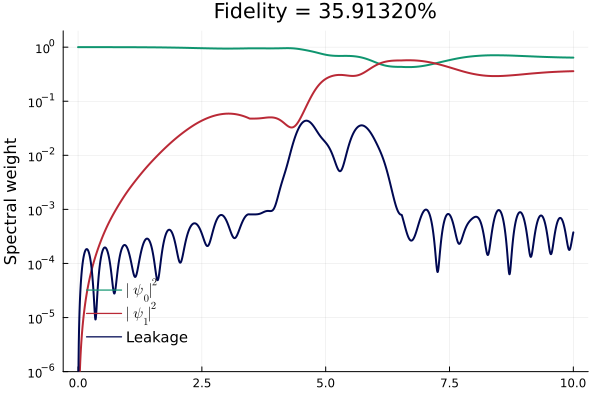

In [48]:
using LaTeXStrings
Occs_plot = plot(sol_f.t,
     [occs[:,1,1], occs[:,2,1], abs.(1 .- (occs[:,1,1] + occs[:,2,1]))],
     yaxis=:log10,
     ylim=(1e-6,2),
     # linewidth=2,
     # yticks=[10^i for i=-5.:0],#(append!([i*10^j for i = 1:9 for j = -5.:-1],[1]),tmp)
     # xlabel=L"$t$ [ns]",
     ylabel="Spectral weight",
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" "Leakage"],
     legend=:bottomleft,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=10,
     # xticks=0:2.5:12.5,
     color=colors2,
     lw=2,
     # xlim=(-0.35,12.75),
     title = "Fidelity = "*string((1 - 0.5*(2-occs[end,1,2] - occs[end,2,1]))*100)[1:8]*"%"
)

In [77]:
# savefig(plt,"FastSwapOccupation.png")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\FastGate\\FastSwapOccupation.png"

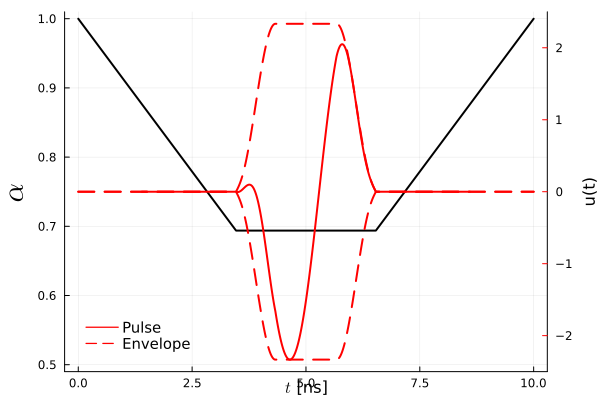

In [49]:
tmp_p = copy(p_new)
tmp_p[6] = 0
# tmp_p[9] = 0
tmp_p[5] = 0

tmp_p2 = copy(p_new)
tmp_p2[6] = 0
# tmp_p2[9] = 0
tmp_p2[5] = pi/2

pulse_plot = plot(times,
     [alpha(p_new,t) for t in times],
     ylim=(0.49,1.01),
     linewidth=2,
#      xlim=(-0.35,12.75),
     color="black",label=nothing,
     labelfontsize=20,ticklabelfontsize=20,
      ylabel=L"$\alpha$")

plot!(twinx(),
      [times[280:1720],times, times],
      [[pulse(p_new,t) for t in times[280:1720]],
       [sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times],
       [-sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times]],
      linewidth=2,
      color=[:red :red :red],
      ylim=(-2.5,2.5),
      # xlim=(-0.35,12.75),
      ls = [:solid :dash :dash],
      label=["Pulse" "Envelope" ""],
      ylabel="u(t)",
      legend=:bottomleft,
      background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontsize=10,
      labelfontsize=11,
      ticklabelfontsize=20,
      axiscolor=:red,
      xlabel=L"$t$ [ns]")

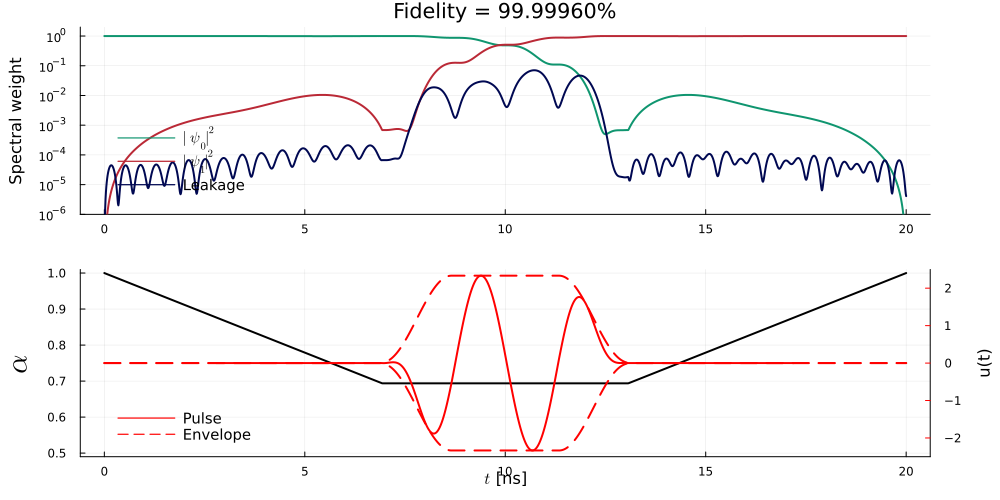

In [27]:
using Plots.PlotMeasures
plt = plot(Occs_plot,pulse_plot,layout=(2,1),size=(1000,500),bottom_margin=20px,right_margin=20px,left_margin=20px)
# savefig(plt,"FastSwapGate2.pdf")

In [124]:
# savefig(plt,"FastSwapGatePulse.png")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\FastGate\\FastSwapGatePulse.png"

In [82]:
limit_func_abs(p_new[2])/12*2000

283.42792589724627

In [51]:
get_T(p_new), 0.5 * (occs[end,1,2] + occs[end,2,1])

(11.915729066780163, 0.9983094692769721)

In [192]:
real(tr(dLdT))*dTdp(p)

9-element Vector{Float64}:
 3.858659226461246e-12
 8.6282243323741e-12
 3.3416969146626496e-12
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [189]:
dp = zeros(Float64,size(p))
dp[1] = 1e-4
res1 = f(p - dp)
res2 = f(p + dp)

0.04760061503113408

In [190]:
(res2 - res1)/(2*dp[1]), -0.6868060220392537

(-0.6874293750433121, -0.6868060220392537)

In [61]:
(res2 - res1)/(2*dp[1]), 0.0011102195813677887

(0.0011102906094517806, 0.0011102195813677887)

In [63]:
(res2 - res1)/(2*dp[2]), -0.0001487009444301983

(-0.00014696657779644795, -0.0001487009444301983)

In [65]:
(res2 - res1)/(2*dp[3]), 0.001216524164690993

(0.0012170017771317987, 0.001216524164690993)